In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 9.7 MB/s 
     |████████████████████████████████| 61 kB 502 kB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 34.3 MB/s 
     |████████████████████████████████| 895 kB 29.6 MB/s 
     |████████████████████████████████| 1.2 MB 7.0 MB/s 


In [ ]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [ ]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(12,1876)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(12,1876)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(12,1876)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [ ]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(2814+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [ ]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [ ]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [ ]:
def get_metrics(actual, predicted, average='micro'):
  return f1_score(actual, predicted, average=average), precision_score(actual, predicted, average=average), recall_score(actual, predicted, average=average)

In [ ]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average))
    results['test_precision'].append(precision_score(test_lbls, test_preds, average=average))
    results['test_recall'].append(recall_score(test_lbls, test_preds, average=average))
    results['test_f1'].append(
        f1_score(test_lbls, test_preds, average=average))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [ ]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [ ]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [ ]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [ ]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [ ]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [ ]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    cv_score = {'train_predictions': [],
                'validation_predictions': [],
                'train_labels': [],
                'validation_labels': [],
                'test_predictions' : [],
                'test_labels' : []
                }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
        cv_score['train_labels'] = cv_score['train_labels'] + best_scores['train_labels'].tolist()
        cv_score['train_predictions'] = cv_score['train_predictions'] + best_scores['train_predictions'].tolist()
        cv_score['validation_labels'] = cv_score['validation_labels'] + best_scores['validation_labels'].tolist()
        cv_score['validation_predictions'] = cv_score['validation_predictions'] + best_scores['validation_predictions'].tolist()
        cv_score['test_labels'] = cv_score['test_labels'] + best_scores['test_labels'].tolist()
        cv_score['test_predictions'] = cv_score['test_predictions'] + best_scores['test_predictions'].tolist()
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    cv_result = {}
    cv_result['validation_f1'], cv_result['validation_precision'], cv_result['validation_recall'] = get_metrics(cv_score['validation_labels'],cv_score['validation_predictions'])
    cv_result['test_f1'], cv_result['test_precision'], cv_result['test_recall'] = get_metrics(cv_score['test_labels'],cv_score['test_predictions'])
    cv_result['train_f1'], cv_result['train_precision'], cv_result['train_recall'] = get_metrics(cv_score['train_labels'],cv_score['train_predictions'])
    print('*** Cross Validation Score ***')
    cv_result = pd.DataFrame(cv_result, index=[0]) # Scalar values
    display(HTML(cv_result.to_html().replace("\\n", "<br>")))
    return results

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_chroma.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [ ]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=42)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

# Fusion with IndicBERT and MEL Spectrogram

In [ ]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.402 / Validation Loss : 3.391 [Time : 15.98111 seconds]
Epoch 2/10 : Training Loss: 3.389 / Validation Loss : 3.383 [Time : 15.579454 seconds]
Epoch 3/10 : Training Loss: 3.382 / Validation Loss : 3.377 [Time : 15.562936 seconds]
Epoch 4/10 : Training Loss: 3.377 / Validation Loss : 3.368 [Time : 15.453613 seconds]
Epoch 5/10 : Training Loss: 3.368 / Validation Loss : 3.361 [Time : 15.422589 seconds]
Epoch 6/10 : Training Loss: 3.360 / Validation Loss : 3.353 [Time : 15.509776 seconds]
Epoch 7/10 : Training Loss: 3.351 / Validation Loss : 3.344 [Time : 15.405907 seconds]
Epoch 8/10 : Training Loss: 3.341 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.400 / Validation Loss : 3.395 [Time : 15.091326 seconds]
Epoch 2/10 : Training Loss: 3.393 / Validation Loss : 3.389 [Time : 15.135812 seconds]
Epoch 3/10 : Training Loss: 3.387 / Validation Loss : 3.383 [Time : 15.096555 seconds]
Epoch 4/10 : Training Loss: 3.382 / Validation Loss : 3.378 [Time : 15.03541 seconds]
Epoch 5/10 : Training Loss: 3.375 / Validation Loss : 3.372 [Time : 14.998939 seconds]
Epoch 6/10 : Training Loss: 3.370 / Validation Loss : 3.366 [Time : 15.095779 seconds]
Epoch 7/10 : Training Loss: 3.364 / Validation Loss : 3.359 [Time : 15.374323 seconds]
Epoch 8/10 : Training Loss: 3.356 / Validation Loss : 3.352 [Time : 15.037027 seconds]
Epoch 9/10 : Training Loss: 3.349 / Validation Loss : 3.344 [Time : 15.075947 seconds]
Epoch 10/10 : Training Loss: 3.343 / Validation Loss : 3.337 [Time : 15.128393 seconds]
*** Confusion Matrix - Training ***
[[ 0  7  0  0  2  0  0  0  0  0  1  0  0  0  0  0 19  1  0  0  0  0  1  2
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.412 / Validation Loss : 3.395 [Time : 15.095192 seconds]
Epoch 2/10 : Training Loss: 3.396 / Validation Loss : 3.387 [Time : 15.086347 seconds]
Epoch 3/10 : Training Loss: 3.389 / Validation Loss : 3.378 [Time : 15.036617 seconds]
Epoch 4/10 : Training Loss: 3.378 / Validation Loss : 3.370 [Time : 15.029749 seconds]
Epoch 5/10 : Training Loss: 3.367 / Validation Loss : 3.360 [Time : 15.074509 seconds]
Epoch 6/10 : Training Loss: 3.361 / Validation Loss : 3.358 [Time : 15.057087 seconds]
Epoch 7/10 : Training Loss: 3.362 / Validation Loss : 3.342 [Time : 15.076693 seconds]
Epoch 8/10 : Training Loss: 3.345 / Validation Loss : 3.330 [Time : 15.197941 seconds]
Epoch 9/10 : Training Loss: 3.328 / Validation Loss : 3.319 [Time : 15.418936 seconds]
Epoch 10/10 : Training Loss: 3.323 / Validation Loss : 3.308 [Time : 15.390866 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  1  0  1  0  0  0  4  0  0  0  0  0  0  0  1  9  0  0  0  0  0 16
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.405 / Validation Loss : 3.398 [Time : 15.273071 seconds]
Epoch 2/10 : Training Loss: 3.398 / Validation Loss : 3.393 [Time : 14.997942 seconds]
Epoch 3/10 : Training Loss: 3.391 / Validation Loss : 3.386 [Time : 15.050356 seconds]
Epoch 4/10 : Training Loss: 3.384 / Validation Loss : 3.379 [Time : 15.022247 seconds]
Epoch 5/10 : Training Loss: 3.376 / Validation Loss : 3.371 [Time : 14.99399 seconds]
Epoch 6/10 : Training Loss: 3.370 / Validation Loss : 3.364 [Time : 15.06515 seconds]
Epoch 7/10 : Training Loss: 3.363 / Validation Loss : 3.357 [Time : 15.063305 seconds]
Epoch 8/10 : Training Loss: 3.355 / Validation Loss : 3.348 [Time : 15.007992 seconds]
Epoch 9/10 : Training Loss: 3.347 / Validation Loss : 3.342 [Time : 14.984812 seconds]
Epoch 10/10 : Training Loss: 3.340 / Validation Loss : 3.344 [Time : 15.074632 seconds]
*** Confusion Matrix - Training ***
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0 25
   0  0  0  0  0  0]


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.403 / Validation Loss : 3.396 [Time : 15.078133 seconds]
Epoch 2/10 : Training Loss: 3.396 / Validation Loss : 3.393 [Time : 15.128295 seconds]
Epoch 3/10 : Training Loss: 3.393 / Validation Loss : 3.388 [Time : 15.011982 seconds]
Epoch 4/10 : Training Loss: 3.388 / Validation Loss : 3.383 [Time : 15.040078 seconds]
Epoch 5/10 : Training Loss: 3.382 / Validation Loss : 3.378 [Time : 14.99237 seconds]
Epoch 6/10 : Training Loss: 3.376 / Validation Loss : 3.374 [Time : 15.024744 seconds]
Epoch 7/10 : Training Loss: 3.375 / Validation Loss : 3.369 [Time : 15.036707 seconds]
Epoch 8/10 : Training Loss: 3.368 / Validation Loss : 3.375 [Time : 15.035113 seconds]
Epoch 9/10 : Training Loss: 3.367 / Validation Loss : 3.361 [Time : 14.997664 seconds]
Epoch 10/10 : Training Loss: 3.363 / Validation Loss : 3.354 [Time : 14.974117 seconds]
*** Confusion Matrix - Training ***
[[ 1  0  0  0  2  0  0  0  2  0 12  0  0  0  0  0  0  0  0  0  1  0  0 15
   0  0  0  0  0  0]

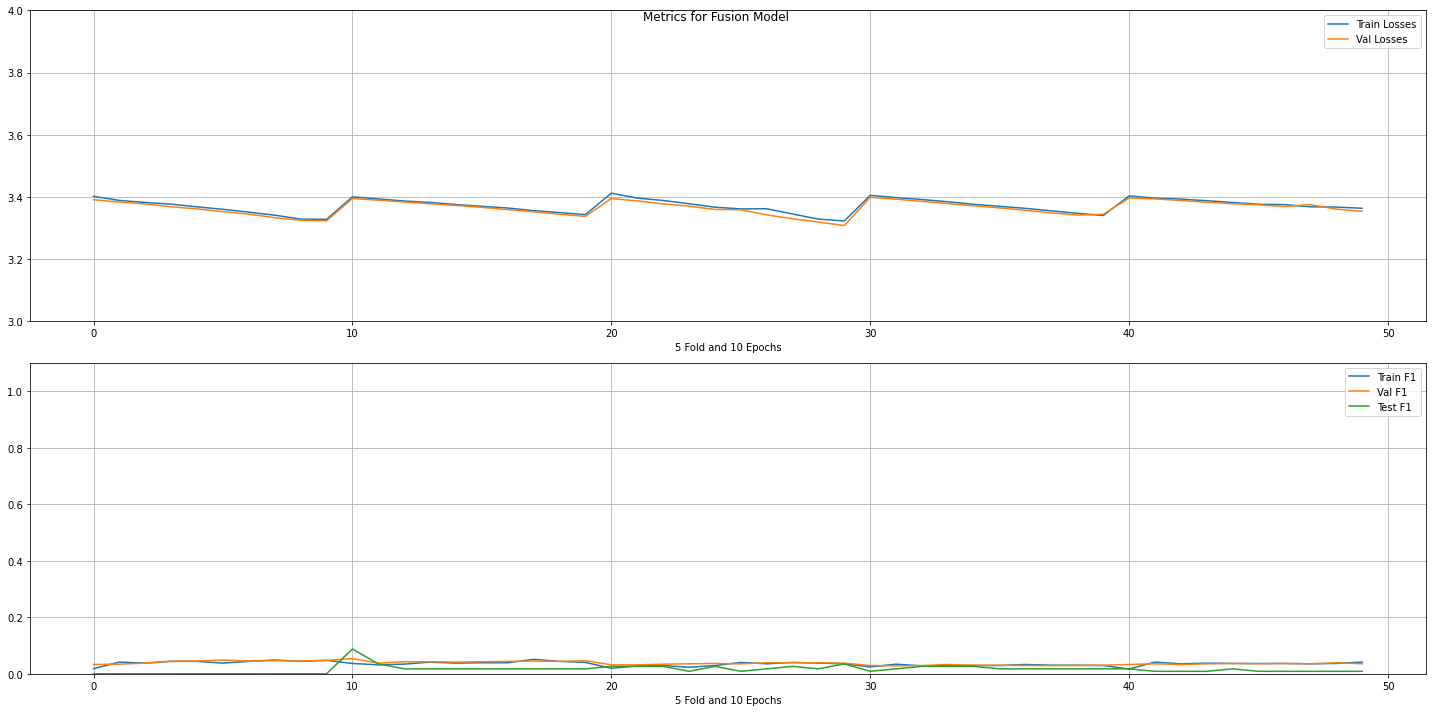

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.039268,0.039268,0.039268,0.015789,0.015789,0.015789,0.039024,0.039024,0.039024


In [ ]:
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
indic_bert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                                fsize=(12,1876))

In [ ]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
0,0.036585,0.053659,0.087719,0.036585,0.053659,0.087719,0.036585,0.053659,0.087719
5,0.037805,0.048780,0.000000,0.037805,0.048780,0.000000,0.037805,0.048780,0.000000
9,0.047561,0.047561,0.000000,0.047561,0.047561,0.000000,0.047561,0.047561,0.000000
7,0.048780,0.046341,0.000000,0.048780,0.046341,0.000000,0.048780,0.046341,0.000000
9,0.040244,0.046341,0.017544,0.040244,0.046341,0.017544,0.040244,0.046341,0.017544
7,0.051220,0.045122,0.017544,0.051220,0.045122,0.017544,0.051220,0.045122,0.017544
3,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000
4,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000
6,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000
8,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000,0.043902,0.045122,0.000000


# MURIL Fusion

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.403 / Validation Loss : 3.397 [Time : 19.08367 seconds]
Epoch 2/10 : Training Loss: 3.395 / Validation Loss : 3.392 [Time : 18.958225 seconds]
Epoch 3/10 : Training Loss: 3.392 / Validation Loss : 3.389 [Time : 19.043856 seconds]
Epoch 4/10 : Training Loss: 3.389 / Validation Loss : 3.384 [Time : 18.924579 seconds]
Epoch 5/10 : Training Loss: 3.386 / Validation Loss : 3.381 [Time : 19.193731 seconds]
Epoch 6/10 : Training Loss: 3.380 / Validation Loss : 3.377 [Time : 18.999627 seconds]
Epoch 7/10 : Training Loss: 3.377 / Validation Loss : 3.376 [Time : 19.177921 seconds]
Epoch 8/10 : Training Loss: 3.377 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.402 / Validation Loss : 3.397 [Time : 15.546449 seconds]
Epoch 2/10 : Training Loss: 3.396 / Validation Loss : 3.393 [Time : 14.903296 seconds]
Epoch 3/10 : Training Loss: 3.392 / Validation Loss : 3.389 [Time : 15.017023 seconds]
Epoch 4/10 : Training Loss: 3.389 / Validation Loss : 3.386 [Time : 14.926358 seconds]
Epoch 5/10 : Training Loss: 3.384 / Validation Loss : 3.381 [Time : 14.938425 seconds]
Epoch 6/10 : Training Loss: 3.380 / Validation Loss : 3.377 [Time : 14.904889 seconds]
Epoch 7/10 : Training Loss: 3.376 / Validation Loss : 3.372 [Time : 14.891005 seconds]
Epoch 8/10 : Training Loss: 3.372 / Validation Loss : 3.367 [Time : 14.881842 seconds]
Epoch 9/10 : Training Loss: 3.368 / Validation Loss : 3.364 [Time : 19.311076 seconds]
Epoch 10/10 : Training Loss: 3.363 / Validation Loss : 3.357 [Time : 19.308803 seconds]
*** Confusion Matrix - Training ***
[[ 0  7 23  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.409 / Validation Loss : 3.400 [Time : 15.517528 seconds]
Epoch 2/10 : Training Loss: 3.399 / Validation Loss : 3.396 [Time : 14.868711 seconds]
Epoch 3/10 : Training Loss: 3.393 / Validation Loss : 3.391 [Time : 14.931588 seconds]
Epoch 4/10 : Training Loss: 3.390 / Validation Loss : 3.386 [Time : 15.005445 seconds]
Epoch 5/10 : Training Loss: 3.387 / Validation Loss : 3.385 [Time : 14.855653 seconds]
Epoch 6/10 : Training Loss: 3.384 / Validation Loss : 3.378 [Time : 14.857716 seconds]
Epoch 7/10 : Training Loss: 3.379 / Validation Loss : 3.374 [Time : 14.821223 seconds]
Epoch 8/10 : Training Loss: 3.374 / Validation Loss : 3.368 [Time : 14.838357 seconds]
Epoch 9/10 : Training Loss: 3.370 / Validation Loss : 3.365 [Time : 14.876511 seconds]
Epoch 10/10 : Training Loss: 3.369 / Validation Loss : 3.369 [Time : 14.871473 seconds]
*** Confusion Matrix - Training ***
[[20  0  1  0  0  0  0  0  1  7  0  0  0  0  0  0  0  1  0  0  0  0  0  2
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.402 / Validation Loss : 3.400 [Time : 15.457725 seconds]
Epoch 2/10 : Training Loss: 3.401 / Validation Loss : 3.400 [Time : 14.86176 seconds]
Epoch 3/10 : Training Loss: 3.399 / Validation Loss : 3.398 [Time : 14.867715 seconds]
Epoch 4/10 : Training Loss: 3.398 / Validation Loss : 3.397 [Time : 14.872312 seconds]
Epoch 5/10 : Training Loss: 3.397 / Validation Loss : 3.396 [Time : 14.850913 seconds]
Epoch 6/10 : Training Loss: 3.396 / Validation Loss : 3.394 [Time : 14.997106 seconds]
Epoch 7/10 : Training Loss: 3.394 / Validation Loss : 3.392 [Time : 14.847446 seconds]
Epoch 8/10 : Training Loss: 3.393 / Validation Loss : 3.392 [Time : 14.853249 seconds]
Epoch 9/10 : Training Loss: 3.391 / Validation Loss : 3.388 [Time : 14.920891 seconds]
Epoch 10/10 : Training Loss: 3.390 / Validation Loss : 3.389 [Time : 14.854926 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  0  0  0  0  0  0  0  0 17  0  0  5  0  0  0  0  0  0  1  0  0 10
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.407 / Validation Loss : 3.398 [Time : 15.6906 seconds]
Epoch 2/10 : Training Loss: 3.398 / Validation Loss : 3.393 [Time : 14.919717 seconds]
Epoch 3/10 : Training Loss: 3.395 / Validation Loss : 3.390 [Time : 14.848407 seconds]
Epoch 4/10 : Training Loss: 3.391 / Validation Loss : 3.386 [Time : 14.882381 seconds]
Epoch 5/10 : Training Loss: 3.391 / Validation Loss : 3.393 [Time : 14.887949 seconds]
Epoch 6/10 : Training Loss: 3.396 / Validation Loss : 3.390 [Time : 14.862415 seconds]
Epoch 7/10 : Training Loss: 3.391 / Validation Loss : 3.385 [Time : 14.840543 seconds]
Epoch 8/10 : Training Loss: 3.383 / Validation Loss : 3.380 [Time : 14.851773 seconds]
Epoch 9/10 : Training Loss: 3.383 / Validation Loss : 3.378 [Time : 14.865337 seconds]
Epoch 10/10 : Training Loss: 3.382 / Validation Loss : 3.377 [Time : 14.832432 seconds]
*** Confusion Matrix - Training ***
[[28  0  1  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0]


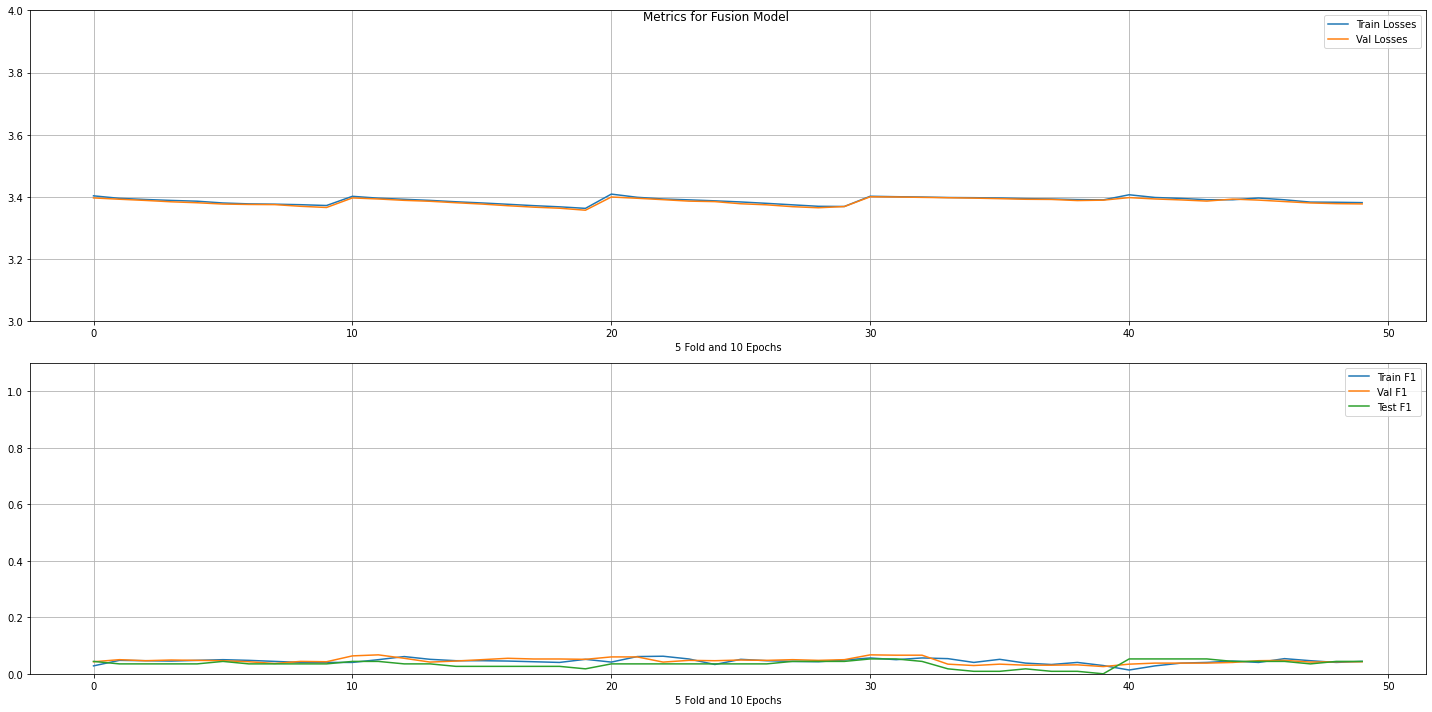

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.043171,0.043171,0.043171,0.029825,0.029825,0.029825,0.043659,0.043659,0.043659


In [ ]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
muril_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                           fsize=(12,1876))

In [ ]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
0,0.056098,0.067073,0.052632,0.056098,0.067073,0.052632,0.056098,0.067073,0.052632
1,0.050000,0.067073,0.043860,0.050000,0.067073,0.043860,0.050000,0.067073,0.043860
2,0.056098,0.065854,0.043860,0.056098,0.065854,0.043860,0.056098,0.065854,0.043860
1,0.050000,0.065854,0.052632,0.050000,0.065854,0.052632,0.050000,0.065854,0.052632
0,0.040244,0.063415,0.043860,0.040244,0.063415,0.043860,0.040244,0.063415,0.043860
1,0.060976,0.059756,0.035088,0.060976,0.059756,0.035088,0.060976,0.059756,0.035088
0,0.041463,0.059756,0.035088,0.041463,0.059756,0.035088,0.041463,0.059756,0.035088
2,0.060976,0.054878,0.035088,0.060976,0.054878,0.035088,0.060976,0.054878,0.035088
6,0.045122,0.054878,0.026316,0.045122,0.054878,0.026316,0.045122,0.054878,0.026316
7,0.042683,0.052439,0.026316,0.042683,0.052439,0.026316,0.042683,0.052439,0.026316


# XLM-R Fusion

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.406 / Validation Loss : 3.391 [Time : 20.971433 seconds]
Epoch 2/10 : Training Loss: 3.390 / Validation Loss : 3.383 [Time : 20.655357 seconds]
Epoch 3/10 : Training Loss: 3.385 / Validation Loss : 3.374 [Time : 20.713676 seconds]
Epoch 4/10 : Training Loss: 3.374 / Validation Loss : 3.365 [Time : 20.606685 seconds]
Epoch 5/10 : Training Loss: 3.368 / Validation Loss : 3.357 [Time : 20.794161 seconds]
Epoch 6/10 : Training Loss: 3.363 / Validation Loss : 3.355 [Time : 20.468408 seconds]
Epoch 7/10 : Training Loss: 3.353 / Validation Loss : 3.339 [Time : 20.523775 seconds]
Epoch 8/10 : Training Loss: 3.347 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.403 / Validation Loss : 3.396 [Time : 15.636917 seconds]
Epoch 2/10 : Training Loss: 3.397 / Validation Loss : 3.392 [Time : 15.559353 seconds]
Epoch 3/10 : Training Loss: 3.393 / Validation Loss : 3.389 [Time : 15.874749 seconds]
Epoch 4/10 : Training Loss: 3.388 / Validation Loss : 3.384 [Time : 15.230932 seconds]
Epoch 5/10 : Training Loss: 3.384 / Validation Loss : 3.379 [Time : 15.225005 seconds]
Epoch 6/10 : Training Loss: 3.378 / Validation Loss : 3.375 [Time : 15.12204 seconds]
Epoch 7/10 : Training Loss: 3.376 / Validation Loss : 3.369 [Time : 15.117607 seconds]
Epoch 8/10 : Training Loss: 3.372 / Validation Loss : 3.362 [Time : 15.159029 seconds]
Epoch 9/10 : Training Loss: 3.365 / Validation Loss : 3.355 [Time : 15.331904 seconds]
Epoch 10/10 : Training Loss: 3.360 / Validation Loss : 3.350 [Time : 15.138298 seconds]
*** Confusion Matrix - Training ***
[[ 2  4 16  0  4  0  0  0  0  0  5  0  0  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.401 / Validation Loss : 3.393 [Time : 15.619733 seconds]
Epoch 2/10 : Training Loss: 3.393 / Validation Loss : 3.387 [Time : 15.539738 seconds]
Epoch 3/10 : Training Loss: 3.386 / Validation Loss : 3.379 [Time : 15.893512 seconds]
Epoch 4/10 : Training Loss: 3.378 / Validation Loss : 3.371 [Time : 15.283246 seconds]
Epoch 5/10 : Training Loss: 3.371 / Validation Loss : 3.365 [Time : 15.160938 seconds]
Epoch 6/10 : Training Loss: 3.367 / Validation Loss : 3.356 [Time : 15.152371 seconds]
Epoch 7/10 : Training Loss: 3.359 / Validation Loss : 3.349 [Time : 15.167238 seconds]
Epoch 8/10 : Training Loss: 3.355 / Validation Loss : 3.341 [Time : 15.150818 seconds]
Epoch 9/10 : Training Loss: 3.346 / Validation Loss : 3.335 [Time : 15.330253 seconds]
Epoch 10/10 : Training Loss: 3.340 / Validation Loss : 3.326 [Time : 15.142444 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  0  3  0  0  0  3  1  0  1  0  0  0  0  0  0  7  0  0  0  1  0 16
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.404 / Validation Loss : 3.395 [Time : 15.606282 seconds]
Epoch 2/10 : Training Loss: 3.395 / Validation Loss : 3.389 [Time : 15.503201 seconds]
Epoch 3/10 : Training Loss: 3.392 / Validation Loss : 3.385 [Time : 15.924651 seconds]
Epoch 4/10 : Training Loss: 3.386 / Validation Loss : 3.380 [Time : 15.155149 seconds]
Epoch 5/10 : Training Loss: 3.382 / Validation Loss : 3.374 [Time : 15.117038 seconds]
Epoch 6/10 : Training Loss: 3.377 / Validation Loss : 3.369 [Time : 15.094369 seconds]
Epoch 7/10 : Training Loss: 3.370 / Validation Loss : 3.363 [Time : 15.142559 seconds]
Epoch 8/10 : Training Loss: 3.364 / Validation Loss : 3.357 [Time : 15.093697 seconds]
Epoch 9/10 : Training Loss: 3.360 / Validation Loss : 3.351 [Time : 15.095485 seconds]
Epoch 10/10 : Training Loss: 3.353 / Validation Loss : 3.341 [Time : 15.125121 seconds]
*** Confusion Matrix - Training ***
[[ 3  0  2  5  1  0  0  4  0  0  4  0  0  0  0  0  0  5  0  0  0  0  0  9
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.404 / Validation Loss : 3.396 [Time : 15.596398 seconds]
Epoch 2/10 : Training Loss: 3.396 / Validation Loss : 3.391 [Time : 15.530524 seconds]
Epoch 3/10 : Training Loss: 3.390 / Validation Loss : 3.386 [Time : 15.82749 seconds]
Epoch 4/10 : Training Loss: 3.386 / Validation Loss : 3.380 [Time : 15.337509 seconds]
Epoch 5/10 : Training Loss: 3.383 / Validation Loss : 3.375 [Time : 15.12595 seconds]
Epoch 6/10 : Training Loss: 3.376 / Validation Loss : 3.370 [Time : 15.123507 seconds]
Epoch 7/10 : Training Loss: 3.373 / Validation Loss : 3.363 [Time : 15.22784 seconds]
Epoch 8/10 : Training Loss: 3.373 / Validation Loss : 3.358 [Time : 15.690894 seconds]
Epoch 9/10 : Training Loss: 3.363 / Validation Loss : 3.354 [Time : 15.160671 seconds]
Epoch 10/10 : Training Loss: 3.355 / Validation Loss : 3.350 [Time : 15.125418 seconds]
*** Confusion Matrix - Training ***
[[ 6  0  4  1  0  0  0  0 13  1  0  0  0  0  0  0  0  7  0  0  0  0  1  0
   0  0  0  0  0  0]
 

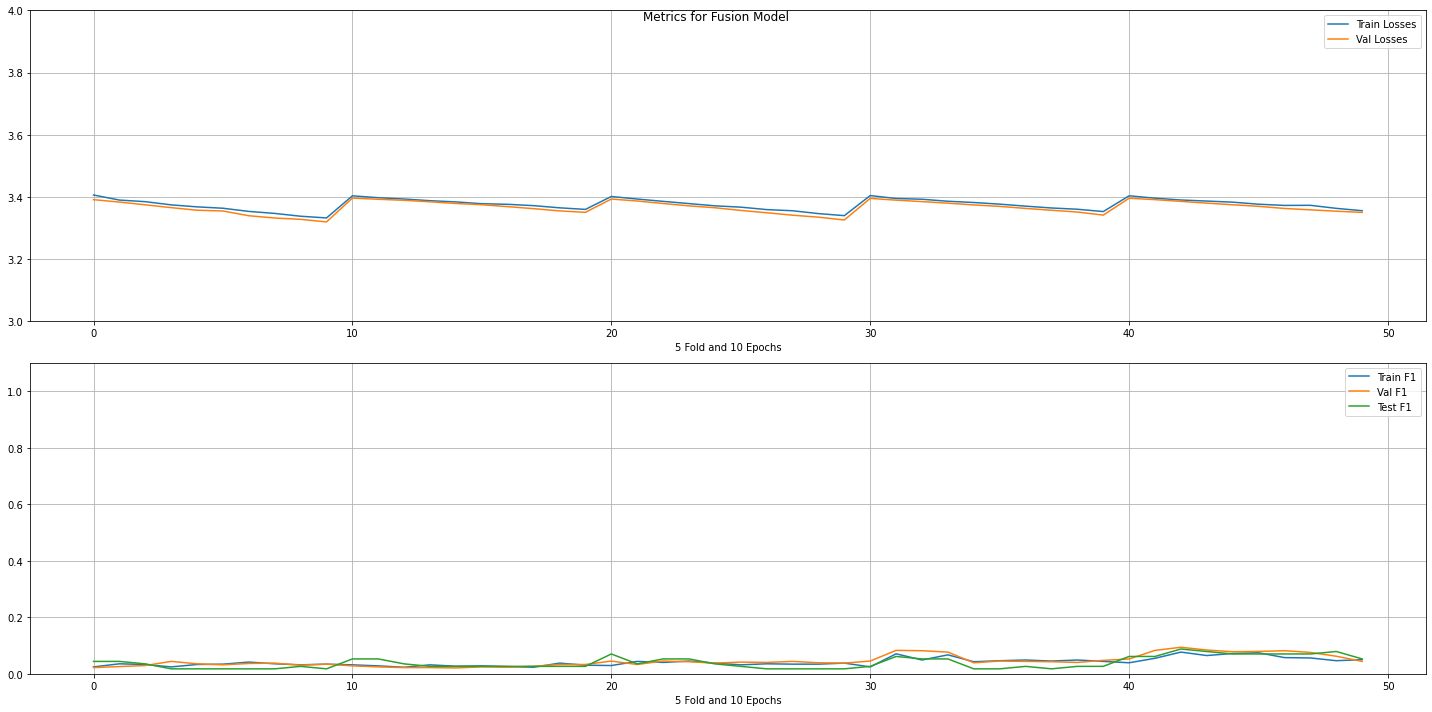

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.039268,0.039268,0.039268,0.02807,0.02807,0.02807,0.039268,0.039268,0.039268


In [ ]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
xlmr_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                          fsize=(12,1876))

In [28]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
2,0.076829,0.093902,0.087719,0.076829,0.093902,0.087719,0.076829,0.093902,0.087719
3,0.064634,0.084146,0.078947,0.064634,0.084146,0.078947,0.064634,0.084146,0.078947
1,0.070732,0.082927,0.061404,0.070732,0.082927,0.061404,0.070732,0.082927,0.061404
1,0.054878,0.082927,0.061404,0.054878,0.082927,0.061404,0.054878,0.082927,0.061404
6,0.057317,0.081707,0.070175,0.057317,0.081707,0.070175,0.057317,0.081707,0.070175
2,0.048780,0.081707,0.052632,0.048780,0.081707,0.052632,0.048780,0.081707,0.052632
5,0.074390,0.079268,0.070175,0.074390,0.079268,0.070175,0.074390,0.079268,0.070175
4,0.071951,0.078049,0.070175,0.071951,0.078049,0.070175,0.071951,0.078049,0.070175
3,0.067073,0.076829,0.052632,0.067073,0.076829,0.052632,0.067073,0.076829,0.052632
7,0.056098,0.075610,0.070175,0.056098,0.075610,0.070175,0.056098,0.075610,0.070175


# MBERT Fusion

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.405 / Validation Loss : 3.386 [Time : 17.628239 seconds]
Epoch 2/10 : Training Loss: 3.383 / Validation Loss : 3.370 [Time : 17.222603 seconds]
Epoch 3/10 : Training Loss: 3.368 / Validation Loss : 3.357 [Time : 16.778561 seconds]
Epoch 4/10 : Training Loss: 3.357 / Validation Loss : 3.344 [Time : 16.750201 seconds]
Epoch 5/10 : Training Loss: 3.343 / Validation Loss : 3.330 [Time : 16.803632 seconds]
Epoch 6/10 : Training Loss: 3.334 / Validation Loss : 3.322 [Time : 16.906067 seconds]
Epoch 7/10 : Training Loss: 3.320 / Validation Loss : 3.309 [Time : 16.913601 seconds]
Epoch 8/10 : Training Loss: 3.317 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.405 / Validation Loss : 3.392 [Time : 14.294379 seconds]
Epoch 2/10 : Training Loss: 3.391 / Validation Loss : 3.386 [Time : 14.358625 seconds]
Epoch 3/10 : Training Loss: 3.386 / Validation Loss : 3.379 [Time : 14.185877 seconds]
Epoch 4/10 : Training Loss: 3.377 / Validation Loss : 3.371 [Time : 14.370183 seconds]
Epoch 5/10 : Training Loss: 3.369 / Validation Loss : 3.364 [Time : 13.975212 seconds]
Epoch 6/10 : Training Loss: 3.365 / Validation Loss : 3.357 [Time : 14.230604 seconds]
Epoch 7/10 : Training Loss: 3.360 / Validation Loss : 3.350 [Time : 13.959655 seconds]
Epoch 8/10 : Training Loss: 3.351 / Validation Loss : 3.342 [Time : 13.943819 seconds]
Epoch 9/10 : Training Loss: 3.358 / Validation Loss : 3.337 [Time : 14.04746 seconds]
Epoch 10/10 : Training Loss: 3.339 / Validation Loss : 3.328 [Time : 13.991573 seconds]
*** Confusion Matrix - Training ***
[[17 13  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.399 / Validation Loss : 3.377 [Time : 14.283286 seconds]
Epoch 2/10 : Training Loss: 3.376 / Validation Loss : 3.361 [Time : 14.235895 seconds]
Epoch 3/10 : Training Loss: 3.360 / Validation Loss : 3.345 [Time : 14.276098 seconds]
Epoch 4/10 : Training Loss: 3.346 / Validation Loss : 3.332 [Time : 13.947406 seconds]
Epoch 5/10 : Training Loss: 3.336 / Validation Loss : 3.320 [Time : 13.975759 seconds]
Epoch 6/10 : Training Loss: 3.325 / Validation Loss : 3.309 [Time : 13.972354 seconds]
Epoch 7/10 : Training Loss: 3.312 / Validation Loss : 3.305 [Time : 13.977807 seconds]
Epoch 8/10 : Training Loss: 3.317 / Validation Loss : 3.291 [Time : 13.963186 seconds]
Epoch 9/10 : Training Loss: 3.301 / Validation Loss : 3.286 [Time : 13.953589 seconds]
Epoch 10/10 : Training Loss: 3.289 / Validation Loss : 3.272 [Time : 17.001826 seconds]
*** Confusion Matrix - Training ***
[[ 0  0 23  0  0  0  0  0  0  6  0  0  0  0  0  0  0  3  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.416 / Validation Loss : 3.393 [Time : 14.343044 seconds]
Epoch 2/10 : Training Loss: 3.392 / Validation Loss : 3.382 [Time : 14.412393 seconds]
Epoch 3/10 : Training Loss: 3.381 / Validation Loss : 3.371 [Time : 13.996059 seconds]
Epoch 4/10 : Training Loss: 3.373 / Validation Loss : 3.362 [Time : 13.93828 seconds]
Epoch 5/10 : Training Loss: 3.360 / Validation Loss : 3.350 [Time : 13.928072 seconds]
Epoch 6/10 : Training Loss: 3.352 / Validation Loss : 3.338 [Time : 13.95446 seconds]
Epoch 7/10 : Training Loss: 3.349 / Validation Loss : 3.332 [Time : 13.962414 seconds]
Epoch 8/10 : Training Loss: 3.338 / Validation Loss : 3.324 [Time : 14.013583 seconds]
Epoch 9/10 : Training Loss: 3.325 / Validation Loss : 3.311 [Time : 13.904434 seconds]
Epoch 10/10 : Training Loss: 3.311 / Validation Loss : 3.302 [Time : 13.944859 seconds]
*** Confusion Matrix - Training ***
[[ 0  0 19  6  0  0  0  0  0  0  3  0  0  0  0  0  0  4  0  0  0  0  0  1
   0  0  0  0  0  0]


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.404 / Validation Loss : 3.403 [Time : 14.253661 seconds]
Epoch 2/10 : Training Loss: 3.401 / Validation Loss : 3.391 [Time : 14.378079 seconds]
Epoch 3/10 : Training Loss: 3.390 / Validation Loss : 3.382 [Time : 13.946345 seconds]
Epoch 4/10 : Training Loss: 3.381 / Validation Loss : 3.373 [Time : 14.061905 seconds]
Epoch 5/10 : Training Loss: 3.375 / Validation Loss : 3.366 [Time : 13.946138 seconds]
Epoch 6/10 : Training Loss: 3.368 / Validation Loss : 3.358 [Time : 13.960388 seconds]
Epoch 7/10 : Training Loss: 3.365 / Validation Loss : 3.354 [Time : 13.95303 seconds]
Epoch 8/10 : Training Loss: 3.356 / Validation Loss : 3.344 [Time : 13.981971 seconds]
Epoch 9/10 : Training Loss: 3.352 / Validation Loss : 3.366 [Time : 13.942166 seconds]
Epoch 10/10 : Training Loss: 3.355 / Validation Loss : 3.345 [Time : 13.964673 seconds]
*** Confusion Matrix - Training ***
[[ 0  0 11  0  1  0  0  0  0  0 15  0  0  0  0  0  0  3  0  0  0  3  0  0
   0  0  0  0  0  0]

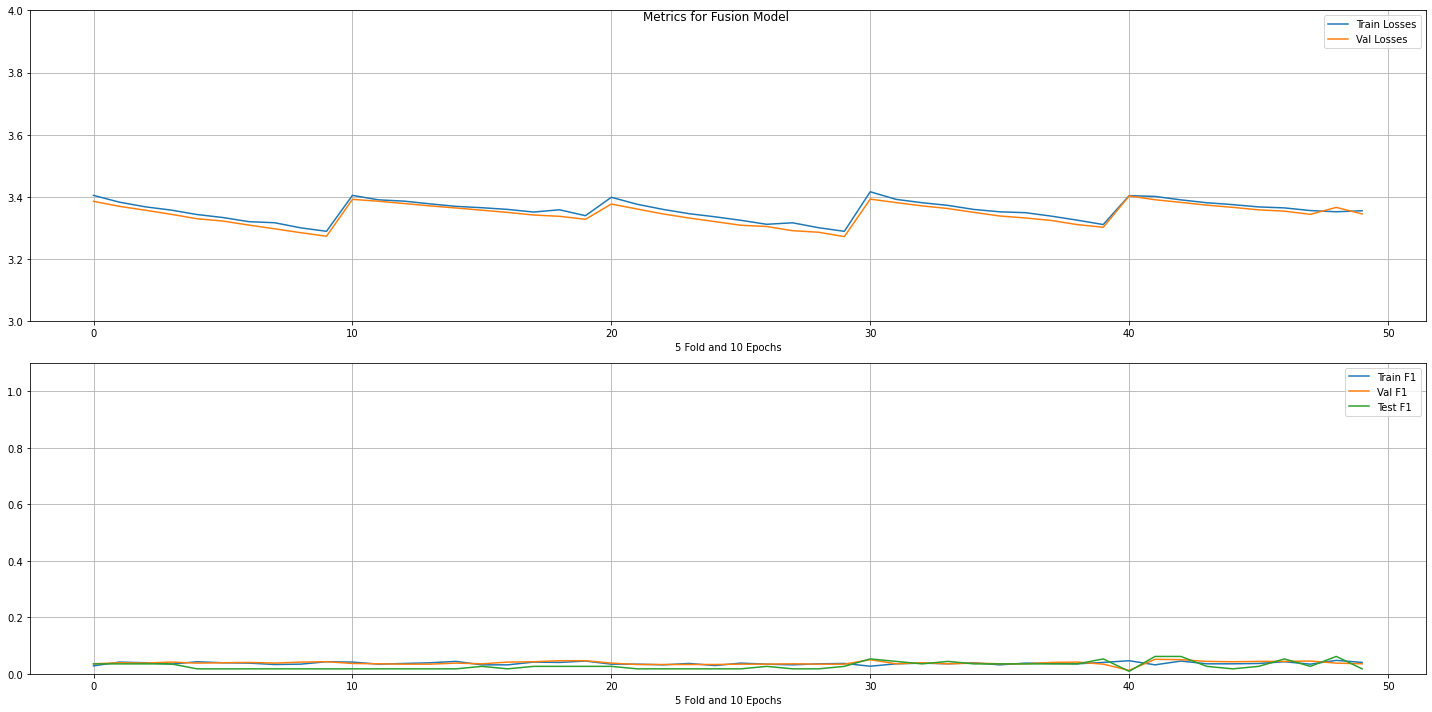

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.040488,0.040488,0.040488,0.029825,0.029825,0.029825,0.039756,0.039756,0.039756


In [26]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
mbert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                           fsize=(12,1876))

In [27]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
1,0.031707,0.051220,0.061404,0.031707,0.051220,0.061404,0.031707,0.051220,0.061404
2,0.045122,0.050000,0.061404,0.045122,0.050000,0.061404,0.045122,0.050000,0.061404
0,0.026829,0.050000,0.052632,0.026829,0.050000,0.052632,0.026829,0.050000,0.052632
9,0.045122,0.046341,0.026316,0.045122,0.046341,0.026316,0.045122,0.046341,0.026316
8,0.040244,0.046341,0.026316,0.040244,0.046341,0.026316,0.040244,0.046341,0.026316
7,0.034146,0.045122,0.026316,0.034146,0.045122,0.026316,0.034146,0.045122,0.026316
6,0.042683,0.043902,0.052632,0.042683,0.043902,0.052632,0.042683,0.043902,0.052632
5,0.036585,0.043902,0.026316,0.036585,0.043902,0.026316,0.036585,0.043902,0.026316
3,0.035366,0.043902,0.026316,0.035366,0.043902,0.026316,0.035366,0.043902,0.026316
9,0.042683,0.042683,0.017544,0.042683,0.042683,0.017544,0.042683,0.042683,0.017544
